<a href="https://colab.research.google.com/github/balados85/deep-learning-brain-mri-classification/blob/main/VGGFinalImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A larger part of this code was adapted from Yixing Fu's project on google colab. The build_model, unreeze and plot_hist functions were adapted and tweaked appropriately for this project. The code was initially implemented for EfficientNet. But We have modified it for the implementation of VGG-16.** [Find original code here](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb)

In [ ]:
!pip install pillow
!pip install cloud_tpu_client

     |████████████████████████████████| 57 kB 5.2 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.272 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow import keras
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights=None)
import PIL.Image
import pathlib

In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
batch_size = 4
IMG_SIZE = 224
original_dataset_dir = 'drive/MyDrive/mri_images/train'

In [ ]:
data_dir = pathlib.Path(original_dataset_dir)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 2042 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 510 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
NUM_CLASSES = int(3)

['0', '1', '2']


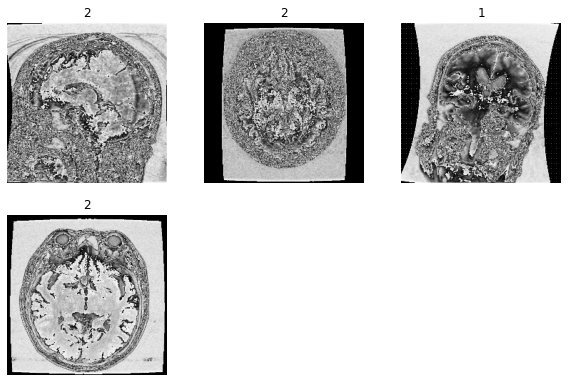

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 224, 224, 3)
(4,)


In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

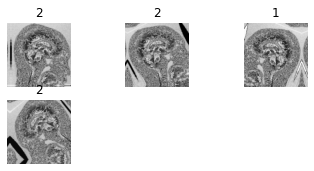

In [ ]:
for image, label in train_ds.take(1):
    for i in range(4):
        aug_img = img_augmentation(image)
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    x = preprocess_input(x)
    model = VGG16(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="VGG16")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


58892288/58889256 [==============================] - 0s 0us/step
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job

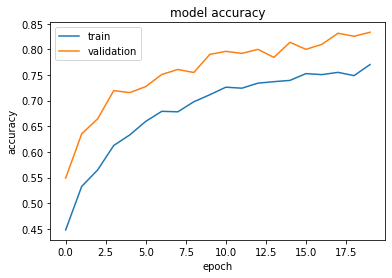

This image most likely belongs to 1 with a 54.86 percent confidence.


In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

    epochs = 20  # @param {type: "slider", min:8, max:80}
    hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)


plot_hist(hist)

img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=(IMG_SIZE,IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
) 

Epoch 1/50
511/511 - 52s - loss: 0.7505 - accuracy: 0.6783 - val_loss: 56.9185 - val_accuracy: 0.2510
Epoch 2/50
511/511 - 44s - loss: 0.5879 - accuracy: 0.7640 - val_loss: 1.3647 - val_accuracy: 0.6314
Epoch 3/50
511/511 - 44s - loss: 0.7019 - accuracy: 0.7184 - val_loss: 1.2499 - val_accuracy: 0.5824
Epoch 4/50
511/511 - 44s - loss: 0.7167 - accuracy: 0.6964 - val_loss: 2.6609 - val_accuracy: 0.4667
Epoch 5/50
511/511 - 45s - loss: 0.5265 - accuracy: 0.8046 - val_loss: 1.9644 - val_accuracy: 0.6314
Epoch 6/50
511/511 - 44s - loss: 0.4869 - accuracy: 0.8208 - val_loss: 6.1527 - val_accuracy: 0.3961
Epoch 7/50
511/511 - 44s - loss: 0.4817 - accuracy: 0.8198 - val_loss: 1.3512 - val_accuracy: 0.5431
Epoch 8/50
511/511 - 44s - loss: 0.4282 - accuracy: 0.8472 - val_loss: 0.5655 - val_accuracy: 0.7627
Epoch 9/50
511/511 - 45s - loss: 0.4187 - accuracy: 0.8550 - val_loss: 0.3863 - val_accuracy: 0.8549
Epoch 10/50
511/511 - 44s - loss: 0.4690 - accuracy: 0.8306 - val_loss: 3.5427 - val_accur

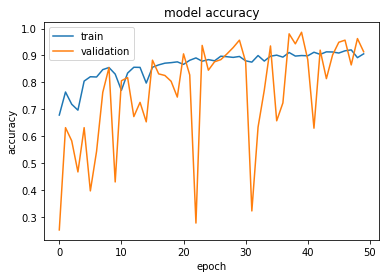

This image most likely belongs to 1 with a 57.61 percent confidence.


In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 50  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=(IMG_SIZE,IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
model.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584